# Analysis of Parking Ticket Citations in the City of Los Angeles 

## Ares Vlahos, Chris Conover, Keegan Black

The overarching goal of this tutorial is to analyze data of Los Angeles parking violations. We take public data from the Los Angeles government and attempt to extract more meaningful information from it through various forms of analysis. 

In [4]:
import pandas as pd
from sodapy import Socrata
import seaborn as sns
import matplotlib as plt
import gmplot
import numpy as np 
import os
import numpy.random
import itertools
import plotly.plotly as py
import plotly.graph_objs as go
import re

## Data Aqcuisition 

Socrata is a public API provided by the City of Los Angeles. We had to import the Socrata package in order to be able to use this API. We use the public authentication token "8yfh-4gug", because we only have public access. 

Using the Socrata client we query for the first 2000 results in their database. We then store this as a record, and convert to a DataFrame to make the data easier to work with. 

The first 2000 results is data from 2015, the year they started using the program. Use caution before querying too frequently because the server has strict throttling limits for public users like ourselves

In [5]:
#Socrata is a public API provided 
client = Socrata("data.lacity.org", None)
results = client.get("8yfh-4gug", limit=2000)
results_df = pd.DataFrame.from_records(results)
results_df

,agency,body_style,color,fine_amount,issue_date,issue_time,latitude,location,longitude,make,marked_time,meter_id,plate_expiry_date,route,rp_state_plate,ticket_number,violation_code,violation_description
0,1,PA,GY,50,2015-12-21T00:00:00.000,1251,99999,13147 WELBY WAY,99999,HOND,NaN,NaN,200304,01521,CA,1103341116,4000A1,NO EVIDENCE OF REG
1,1,VN,WH,50,2015-12-21T00:00:00.000,1435,99999,525 S MAIN ST,99999,GMC,NaN,NaN,201512,1C51,CA,1103700150,4000A1,NO EVIDENCE OF REG
2,2,PA,BK,58,2015-12-21T00:00:00.000,2055,6439997.9,200 WORLD WAY,1802686.4,NISS,NaN,NaN,201503,2R2,CA,1104803000,8939,WHITE CURB
3,2,PA,WH,NaN,2015-12-26T00:00:00.000,1515,6440041.1,100 WORLD WAY,1802686.2,ACUR,NaN,NaN,NaN,2F11,CA,1104820732,000,17104h
4,1,PA,BK,93,2015-09-15T00:00:00.000,115,99999,GEORGIA ST/OLYMPIC,99999,CHEV,NaN,NaN,200316,1FB70,CA,1105461453,8069A,NO STOPPING/STANDING
5,1,VN,GY,50,2015-09-15T00:00:00.000,19,99999,SAN PEDRO S/O BOYD,99999,CHEV,NaN,NaN,201507,1A35W,CA,1106226590,4000A1,NO EVIDENCE OF REG
6,1,PA,BL,163,2015-12-17T00:00:00.000,1710,99999,SUNSET/ALVARADO,99999,MAZD,NaN,NaN,201605,00217,CA,1106500452,8070,PARK IN GRID LOCK ZN
7,1,PA,BK,163,2015-12-17T00:00:00.000,1710,99999,SUNSET/ALVARADO,99999,TOYO,NaN,NaN,201602,00217,CA,1106500463,8070,PARK IN GRID LOCK ZN
8,1,PA,BR,93,2015-12-22T00:00:00.000,945,99999,721 S WESTLAKE,99999,CHEV,NaN,NaN,201605,2A75,CA,1106506402,8069AA,NO STOP/STAND AM
9,1,PA,SI,93,2015-12-22T00:00:00.000,1100,99999,1159 HUNTLEY DR,99999,NISS,NaN,NaN,201701,2A75,CA,1106506413,8069AA,NO STOP/STAND AM


## Data Tidying 

There are some features being recored here that are not useful to our analysis. We decide to remove these columns entirely, so we drop them from the DataFrame. Other features contained NaN values, so we remove any rows containing a NaN value to make analysis much easier. 

The "issue_date" column's format is not very helpful analytically in the format it comes in. To further tidy the data and make interpretation easier, we expand the "issue_date" column into three new columns: "Month", "Date", "Year".

In [6]:
tidy_df = results_df.drop(['agency', 'meter_id', 'plate_expiry_date', 'route', 'ticket_number', 'marked_time'], axis=1)
df_drop = tidy_df.dropna()
year_arr = []
month_arr = []
day_arr = []

for index, row in df_drop.iterrows():
    date = re.search('([0-9]{4})\-([0-9]{2})\-([0-9]{2}).*', row['issue_date'])
    year_arr.append(date.group(1))
    month_arr.append(date.group(2))
    day_arr.append(date.group(3))

df_drop = df_drop.drop(['issue_date'], axis=1)

df_drop.insert(loc=4, column='Day', value=day_arr)
df_drop.insert(loc=5, column='Month', value=month_arr)
df_drop.insert(loc=6, column='Year', value=year_arr)

df_drop.head()

,body_style,color,fine_amount,issue_time,Day,Month,Year,latitude,location,longitude,make,rp_state_plate,violation_code,violation_description
0,PA,GY,50,1251,21,12,2015,99999,13147 WELBY WAY,99999,HOND,CA,4000A1,NO EVIDENCE OF REG
1,VN,WH,50,1435,21,12,2015,99999,525 S MAIN ST,99999,GMC,CA,4000A1,NO EVIDENCE OF REG
2,PA,BK,58,2055,21,12,2015,6439997.9,200 WORLD WAY,1802686.4,NISS,CA,8939,WHITE CURB
4,PA,BK,93,115,15,09,2015,99999,GEORGIA ST/OLYMPIC,99999,CHEV,CA,8069A,NO STOPPING/STANDING
5,VN,GY,50,19,15,09,2015,99999,SAN PEDRO S/O BOYD,99999,CHEV,CA,4000A1,NO EVIDENCE OF REG


## Exploratory Analysis

### Analyzing Time of Day

The first look we took at this data was what time of day the most tickets are given out. There are three large spikes in this data at around approximately 9 A.M.,11 A.M., and 5 P.M.. Our assumption here was that these correspond with the typical commuter schedule. These are the time periods when people are moving their cars the most. 

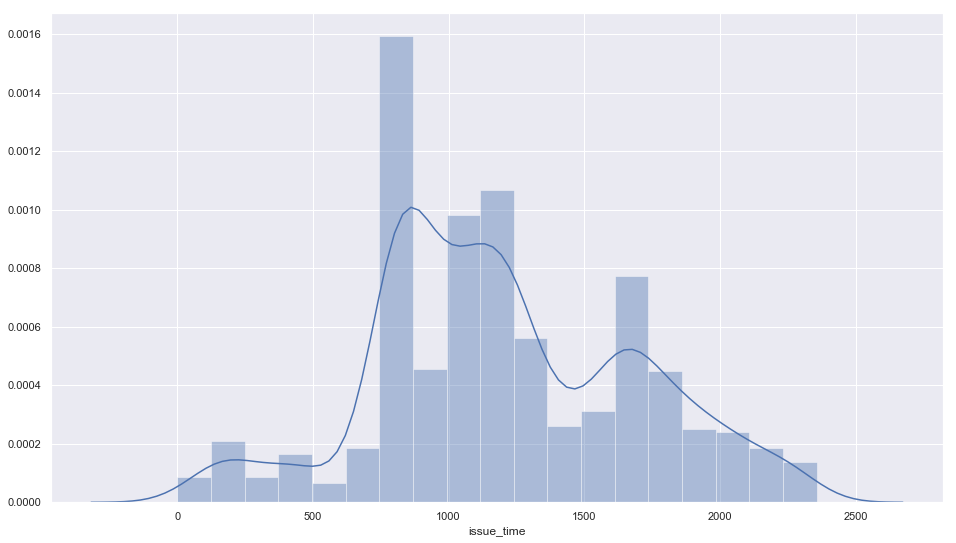

In [7]:
sns.set(rc={'figure.figsize':(16.0,9.0)})
sns.distplot(df_drop['issue_time'].apply(int), kde = True)

### Analyzing vehicle model

The next way we look at the data is total number of citations given based on the car make. This is done by making a dictionary. The key will be the make of the car, and the value is the total number of tickets. 

We iterate through each row of the proper column and construct the corresponding dictionary, adding one to the value for each occurence. These values are used to make the sorted bar graph that can be seen. 

This data is interesting because there may be many confounding variables. A rich person with a nice model of car may care about the fine less, and therefore commit more violations. However, the data shows Toyota, Honda, and Chevy are the three makes with the most violations. 

It is too early, and bad practice, to make assumptions about the data at this point. However, it seems that the most common car brands make up for the most total violations. This makes sense so we continue with our analysis.

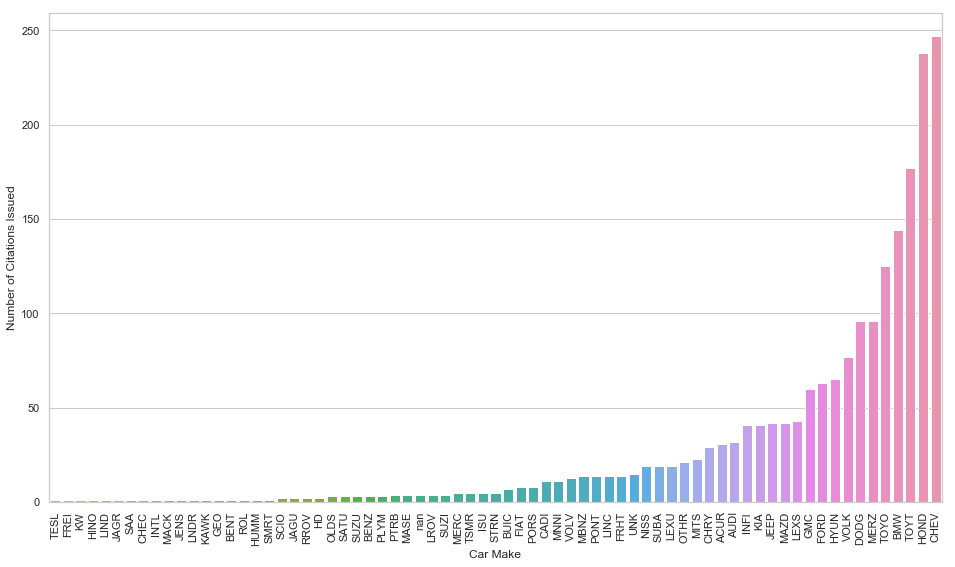

In [8]:
count_dict = {}

for index, row in results_df.iterrows():
    try:
        count_dict[row['make']] = count_dict[row['make']] + 1
    except:
        count_dict[row['make']] = 1

count_dict = {k:v for k,v in count_dict.items()}
sorted_arr_vals = np.array(sorted(count_dict.values())) # This will be the y-axis

i = 0
sorted_key_vals = [None] * len(sorted_arr_vals)

uniq_lst = {x[0] for x in itertools.groupby(sorted(sorted_arr_vals))}

for elt in uniq_lst:
    for key in count_dict:
        if count_dict[key] == elt:
            sorted_key_vals[i] = key
            i = i + 1

# sorted_key_vals
skv = np.array(sorted_key_vals)

df = pd.DataFrame({'Car Make':skv, 'Number of Citations Issued':sorted_arr_vals})

plt.pyplot.figure()
sns.set(rc={'figure.figsize':(16.0,9.0)})
sns.set(style="whitegrid")
ax = sns.barplot(x="Car Make", y="Number of Citations Issued", data=df).set_xticklabels(sorted_key_vals, rotation=90)

### Analyzing vehicle color

We essentially repeat the same process as we did with the "make" column, but this time with the "color" column. Our intuition in analyzing this data is that there may be underlying psychology that influences ticket violation. For example, red cars generally recieve higher insurance cost because correlation has been shown that they speed more.

But once again we see that in large numbers, the average is revealed. Three very common neutral colors black, white, and grey, are recieving the most number of citations. It seems once again, perhaps unsurprisingly, that the common car colors recieve the most total ticket citations. 

In [9]:
color_lst = []

for index, row in results_df.iterrows():
    if row['color'] not in color_lst:
        try:
            row['color'] = row['color'] + 1
        except:
            color_lst.append(row['color'])

count_dict = {}

for index, row in results_df.iterrows():
    if row['color'] in color_lst:
        try:
            count_dict[row['color']] = count_dict[row['color']] + 1
        except:
            count_dict[row['color']] = 1

sorted_vals = np.array(sorted(count_dict.values())) # y-axis
uniq_vals = np.unique(sorted_vals)

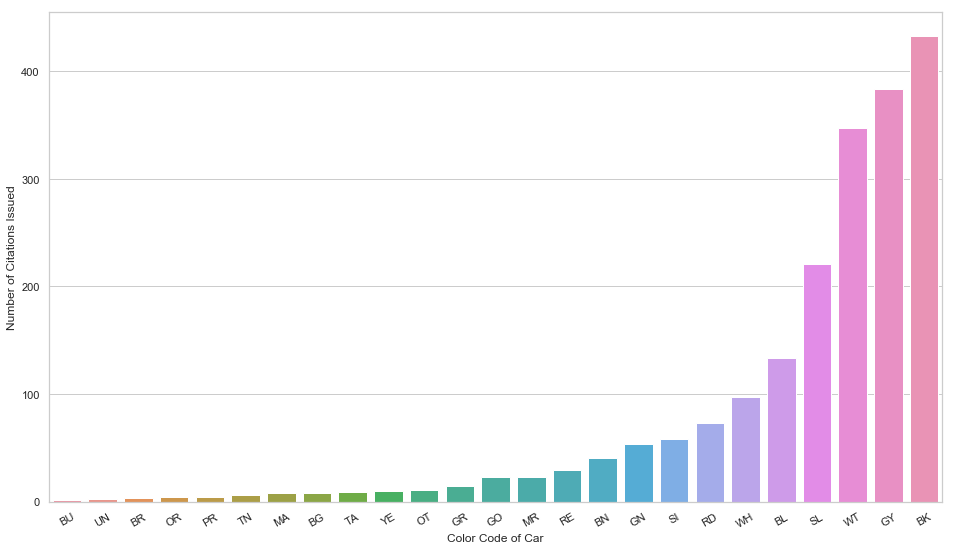

In [10]:
ordered_color_lst = []

for elt in uniq_vals:
    for key,val in count_dict.items():
        if elt == val:
            ordered_color_lst.append(key)

np_color_lst = np.array(ordered_color_lst)

df2 = pd.DataFrame({'Color Code of Car':np_color_lst, 'Number of Citations Issued':sorted_vals})

plt.pyplot.figure()
sns.set(rc={'figure.figsize':(16.0,9.0)})
sns.set(style="whitegrid")
bx = sns.barplot(x="Color Code of Car", y="Number of Citations Issued", data=df2).set_xticklabels(np_color_lst, rotation=30)

### Analyzing Most Frequent Violations

The next thing we do is take a look at the most frequent parking violations. We take the count of each unique "violation_code" which luckily returns already sorted. So we can simply grab the first ten entries and plot them on a bar graph. 

We see that one violation code "80.69BS" accounts for a lot of the violations given, even among the top ten violations. This violation code corresponds to a fine for lack of parking permit, or not moving your car on a sweeping day. This makes sense as the most frequent violation. 

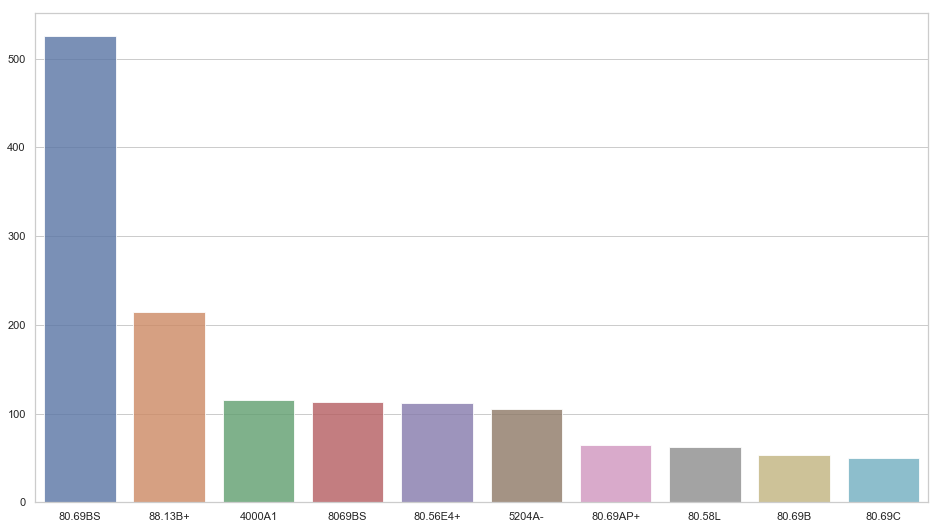

In [11]:
latitudes = df_drop["latitude"]
longitudes = df_drop["longitude"]
violation_counts = df_drop['violation_code'].value_counts()
violation_counts = violation_counts[:10,]
sns.barplot(violation_counts.index, violation_counts.values, alpha=0.8)

### Distribution of Violation Codes

This constructs a histogram showing the distribution over time of each of the top ten violations. We can see that almost all of the parking violations given are in the morning. This matches what we saw earlier in the first analysis. The two most frequent violations are given out at relatively the same time. The rest of the violations are given out at relatively the same frequency in the later periods of the day. 

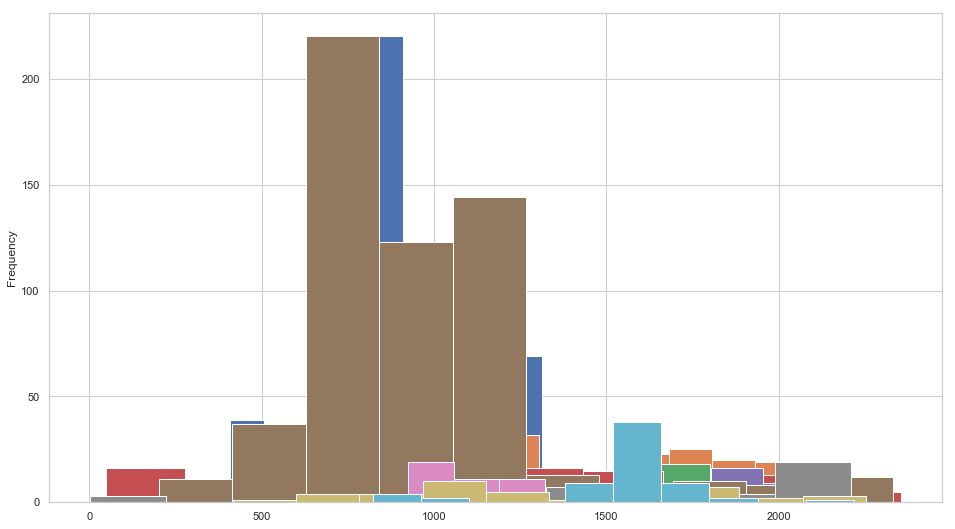

In [12]:
top_ten_list = ["80.69BS", "88.13B+","5204A-", "80.56E4+","80.58L","80.69B","80.69C","80.56E1", "5200", "80.69AP+"]

top_ten = df_drop[df_drop.violation_code.isin(top_ten_list)]

for entry in top_ten_list:
            is_entry =  top_ten['violation_code'].str.match(entry)
            entries = top_ten[is_entry]
            entries["issue_time"].apply(int).plot(kind='hist')       

plt.pyplot.show()

### Analysis, Hypothesis Testing and Machine Learning

In [13]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Fixed seed for reproducibility
kSEED = 5
np.random.seed(kSEED)
results_df.head()

,agency,body_style,color,fine_amount,issue_date,issue_time,latitude,location,longitude,make,marked_time,meter_id,plate_expiry_date,route,rp_state_plate,ticket_number,violation_code,violation_description
0,1,PA,GY,50,2015-12-21T00:00:00.000,1251,99999,13147 WELBY WAY,99999,HOND,NaN,NaN,200304,01521,CA,1103341116,4000A1,NO EVIDENCE OF REG
1,1,VN,WH,50,2015-12-21T00:00:00.000,1435,99999,525 S MAIN ST,99999,GMC,NaN,NaN,201512,1C51,CA,1103700150,4000A1,NO EVIDENCE OF REG
2,2,PA,BK,58,2015-12-21T00:00:00.000,2055,6439997.9,200 WORLD WAY,1802686.4,NISS,NaN,NaN,201503,2R2,CA,1104803000,8939,WHITE CURB
3,2,PA,WH,NaN,2015-12-26T00:00:00.000,1515,6440041.1,100 WORLD WAY,1802686.2,ACUR,NaN,NaN,NaN,2F11,CA,1104820732,000,17104h
4,1,PA,BK,93,2015-09-15T00:00:00.000,115,99999,GEORGIA ST/OLYMPIC,99999,CHEV,NaN,NaN,200316,1FB70,CA,1105461453,8069A,NO STOPPING/STANDING


In [14]:
encoder = LabelEncoder()


In [15]:
class Example:

    def __init__(self, features, label):
        self.features = features
        self.label = label

data = []
for row in results_df.itertuples():
    label = row[-1]
    features = row[1:-1]
    example = Example(features, label)
    data.append(example)
    
data = shuffle(data, random_state=kSEED)

X = [example.features for example in data]
y = [example.label for example in data]

encoded_y = encoder.fit_transform(y)
dummy_y = pd.get_dummies(encoded_y).values

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,dummy_y,test_size=0.2, random_state=kSEED)

print('Total Examples: {:}\nTrain Examples: {:}\nTest Examples: {:4d}'.format(len(data), len(X_train), len(X_test)))

Total Examples: 2000
Train Examples: 1600
Test Examples:  400


In [17]:
model = Sequential()
model.add(Dense(16,input_shape=(13,),activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(135,activation='softmax'))

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                224       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 135)               2295      
Total params: 2,791
Trainable params: 2,791
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(np.array(X_train), np.array(y_train), epochs=100, batch_size=10)

ValueError: Error when checking input: expected dense_1_input to have shape (13,) but got array with shape (17,)